In [93]:
import pandas as pd
from sklearn.model_selection import GridSearchCV,cross_val_score,cross_val_predict,train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import log_loss,roc_auc_score,roc_curve,accuracy_score
import datetime
from  sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import math
from matplotlib import pyplot as plt

In [69]:
data=pd.read_csv('data_for_modeling.csv')
data.drop(columns=['Season', 'DayNum','big_id', 'small_id','Team_bigid', 'Conf_bigid',
                  'W.L_bigid','Team_smallid', 'Conf_smallid', 'W.L_smallid'],inplace=True)
Y=data['smallid_won']
X=data.drop(columns='smallid_won')

In [70]:
x, x_test, y, y_test = train_test_split(X, Y, test_size=0.20, random_state = 8)

# Features' names --
features = X.columns

#Scale data --
scaler = StandardScaler()
x = scaler.fit_transform(x)
x_test = scaler.transform(x_test)

# Check sample/test size
print('Train: \n{:1,} rows &'.format(x.shape[0]),'{:1,} columns'.format(x.shape[1]))
print('Test: \n{:1,} rows &'.format(x_test.shape[0]),'{:1,} columns'.format(x_test.shape[1]))

Train: 
159 rows & 20 columns
Test: 
40 rows & 20 columns


In [78]:
a = datetime.datetime.now()
param_test = {
    'max_depth' : [1],
    'learning_rate' : [.12,0.15,.18],
    'min_samples_leaf':[10,20,30],
    'min_samples_split':[40,50,60],
    'n_estimators' : [20,30,40],
    'subsample' : [.75,.8,.9]
            }
# Set grid-search --
gsearch = GridSearchCV(
    GradientBoostingClassifier(
        random_state=0,
        max_features='auto',
    ), 
    param_grid = param_test, 
    scoring='neg_log_loss',
    n_jobs=-1, 
    cv=5)  
#Run Grid search --
gsearch.fit(x,y)
b = datetime.datetime.now()
print('Run-time:',b - a)
#CV Results
print('Best Parameters:',gsearch.best_params_)

Run-time: 0:00:01.662552
Best Parameters: {'learning_rate': 0.18, 'max_depth': 1, 'min_samples_leaf': 30, 'min_samples_split': 40, 'n_estimators': 30, 'subsample': 0.8}


In [79]:
# Estimate prob - train set --
ytrain_prob = gsearch.predict_proba(x)[:, 1]
ytrain_hat = gsearch.predict(x)
train=pd.DataFrame(data={'WP':ytrain_prob,'Predicted':ytrain_hat},index=y.index)
train['Outcome'] = y
train['Resid'] = train['Outcome'] - train['WP']
se_t = train['Resid']**2
mse_t = se_t.values.mean()
rmse_t = math.sqrt(mse_t)
train_accuracy = log_loss(y.values,ytrain_hat)
# Print Results --
print('Gradient Boosting Classifier train log loss: \n{:.2%}'.format(train_accuracy))
print('Train RMSE: \n{:.2%}'.format(rmse_t))
print('Train MSE: \n{:.2%}'.format(mse_t))

Gradient Boosting Classifier train log loss: 
543.07%
Train RMSE: 
32.77%
Train MSE: 
10.74%


In [81]:
# Estimate prob - test set --
ytest_prob = gsearch.predict_proba(x_test)[:, 1]
ytest_hat = gsearch.predict(x_test)
test = pd.DataFrame(data={'WP':ytest_prob,'Predicted':ytest_hat},index= y_test.index)
test['Outcome'] = y_test
test['Resid'] = test['Outcome'] - test['WP']
se = test['Resid']**2
mse = se.values.mean()
rmse = math.sqrt(mse)
test_accuracy = log_loss(y_test.values,ytest_hat)
# Print Results --
print('Gradient Boosting Classifier test log loss: \n{:.2%}'.format(test_accuracy,4))
print('Test RMSE: \n{:.2%}'.format(rmse))
print('Test MSE: \n{:.2%}'.format(mse))

Gradient Boosting Classifier test log loss: 
1208.87%
Test RMSE: 
44.53%
Test MSE: 
19.83%


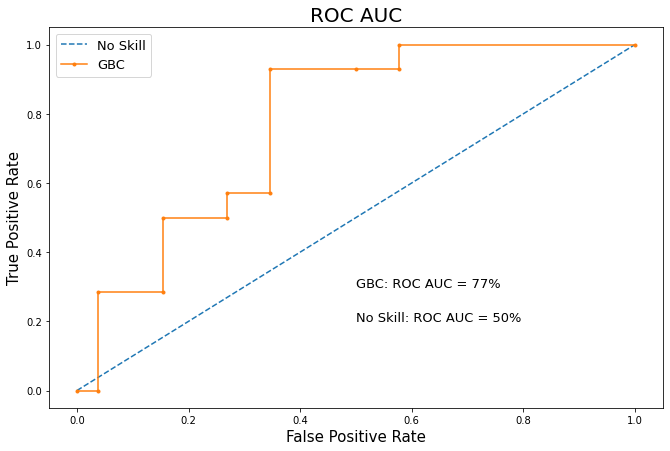

In [88]:
lr_probs = gsearch.predict_proba(x_test)[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.figure(figsize=(11,7))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='GBC')
# axis labels
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
#Legend
plt.legend(loc=2, prop={'size': 13})
#text
plt.text(.5, .3,'GBC: ROC AUC = {:.0%}'.format(lr_auc), fontsize=13)
plt.text(.5, .2,'No Skill: ROC AUC = {:.0%}'.format(ns_auc), fontsize=13)
#Title
plt.title("ROC AUC",fontsize=20)
# show the plot
plt.show()

In [94]:
#Predicted 65% of test games correctly
accuracy_score(y_test.values,ytest_hat)

0.65

<ipython-input-96-09334fbc39be>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('features.png', dpi=400, facecolor='w', edgecolor='w',
<ipython-input-96-09334fbc39be>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('features.png', dpi=400, facecolor='w', edgecolor='w',


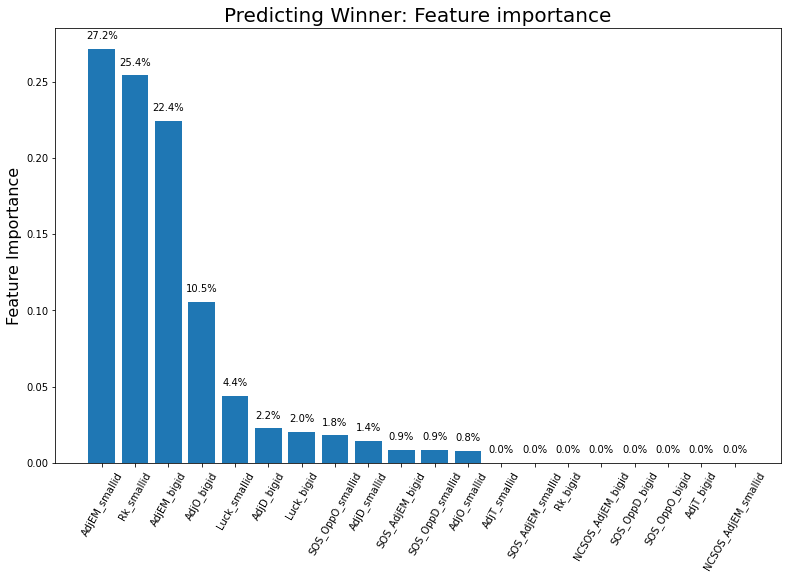

In [96]:
featu = pd.DataFrame(data = {'feat':features,'import':gsearch.best_estimator_.feature_importances_})
featu=featu.sort_values(by='import',ascending=False)
a = featu['feat']
b = featu['import']
plt.figure(figsize=(13,8))
plt.bar(a,b)
# zip joins x and y coordinates in pairs
for a,b in zip(a,b):
    label = "{:.1%}".format(b)
    plt.annotate(label,
                 (a,b), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 
plt.title("Predicting Winner: Feature importance",fontsize=20)
plt.xticks(rotation=60)
plt.ylabel("Feature Importance",fontsize=16)
# plt.savefig('features.png', dpi=400, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
plt.show()